## **Fake News Detection**
Gowtham Raju A          50475997

Pavithra P              50496102

Nikhil Sai Sarath V     50496134

# Basic Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
folder_path = '/content/drive/My Drive/DL/fake_news/src'
os.chdir(folder_path)

Mounted at /content/drive


In [2]:
proj_dir = '/content/drive/MyDrive/DL/fake_news'
%pwd

'/content/drive/MyDrive/DL/fake_news/src'

In [3]:
!pip install optuna

import nltk
import torch
import pickle
import optuna
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


cuda


[nltk_data] Downloading package wordnet to /root/nltk_data...


# 1. LSTM Model

## Load and Preprocess data

In [4]:
from fakenews.preprocess import combine_dataset, clean_text
liar, fkn, lstm_df = combine_dataset(proj_dir)

In [5]:
liar

,text,label
0,We have less Americans working now than in the...,1
1,Says Having organizations parading as being so...,0
2,Says nearly half of Oregons children are poor.,1
3,On attacks by Republicans that various program...,1
4,Says when armed civilians stop mass shootings ...,0
...,...,...
11739,Says his budget provides the highest state fun...,1
11740,Ive been here almost every day.,1
11741,"In the early 1980s, Sen. Edward Kennedy secret...",1
11742,Says an EPA permit languished under Strickland...,1


In [6]:
fkn

,text,label
0,National Federation of Independent Business,1
1,comments in Fayetteville NC,1
2,"Romney makes pitch, hoping to close deal : Ele...",1
3,Democratic Leaders Say House Democrats Are Uni...,1
4,"Budget of the United States Government, FY 2008",1
...,...,...
23191,2017 Hollywood Film Awards: The Complete List ...,1
23192,Jada Pinkett Smith explains why son Jaden move...,1
23193,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1
23194,Prince Harry Carries on Princess Diana’s Legac...,1


In [7]:
lstm_df

,text,label
0,We have less Americans working now than in the...,1
1,Says Having organizations parading as being so...,0
2,Says nearly half of Oregons children are poor.,1
3,On attacks by Republicans that various program...,1
4,Says when armed civilians stop mass shootings ...,0
...,...,...
34935,2017 Hollywood Film Awards: The Complete List ...,1
34936,Jada Pinkett Smith explains why son Jaden move...,1
34937,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1
34938,Prince Harry Carries on Princess Diana’s Legac...,1


In [8]:
lstm_df['text'] = lstm_df['text'].map(lambda com : clean_text(com))
lstm_df

,text,label
0,le american working,1
1,say organization parading social welfare organ...,0
2,say nearly half oregon child poor,1
3,attack republican various program economic sti...,1
4,say armed civilian stop mass shooting gun aver...,0
...,...,...
34935,hollywood film award complete list winner,1
34936,jada pinkett smith explains son jaden moved,1
34937,tinsley mortimer reacts luann de lesseps relapse,1
34938,prince harry carry princess diana legacy annou...,1


In [9]:
lstm_df.isnull().sum()

text     0
label    0
dtype: int64

No null values in the data set

In [10]:
round(lstm_df['label'].value_counts(normalize=True) * 100, 2)

1    76.35
0    23.65
Name: label, dtype: float64

## Data Analysis

In [11]:
text_real=lstm_df[lstm_df['label']==1]['text']
text_fake=lstm_df[lstm_df['label']==0]['text']
text_real = ' '.join([''.join(text) for text in text_real])
text_fake = ' '.join([''.join(text) for text in text_fake])

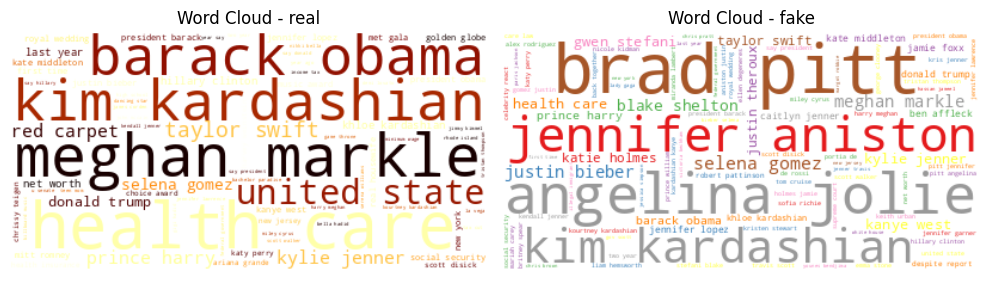

In [12]:
# Word cloud - toxic comments
wordcloud_real = WordCloud(
    collocation_threshold=2,
    collocations=True,
    background_color="white",
    colormap="afmhot"
).generate(text_real )

# Word cloud - nontoxic comments
wordcloud_fake = WordCloud(
    collocation_threshold=2,
    collocations=True,
    background_color="white",
    colormap="Set1"
).generate(text_fake)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("Word Cloud - real")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Word Cloud - fake")
plt.axis("off")

plt.tight_layout()
plt.show()

## Data Preparing

In [13]:
from fakenews.dataset import tokenize

X_train, X_test, y_train, y_test, tokenizer = tokenize(lstm_df, proj_dir, "lstm")

Maximum Sequence Length:  227


In [14]:
# Numpy to Tensors
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

# One-hot encoding
y_train_tensor = torch.nn.functional.one_hot(y_train_tensor.to(torch.int64), num_classes=2)
y_test_tensor = torch.nn.functional.one_hot(y_test_tensor.to(torch.int64), num_classes=2)

# TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Modelling: LSTM

Finding best hyperparameters

In [15]:
from fakenews.model import LSTM
from fakenews.optimization import lstm_objective

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: lstm_objective(trial, train_loader, test_loader, device), n_trials=10)
best_params = study.best_params

best_embedding_dim = best_params['embedding_dim']
best_hidden_dim = best_params['hidden_dim']
best_lr = best_params['learning_rate']

print("\nBest hyperparameters:", best_params)

input_dim = 5000  # Vocab size
output_dim = 2  # Binary

model = LSTM(input_dim, best_embedding_dim, best_hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss().to(device)
print(model)

[I 2023-12-11 01:51:06,708] A new study created in memory with name: no-name-35c4cb52-7f31-4d84-b0fb-f8838600d338
[I 2023-12-11 01:51:59,351] Trial 0 finished with value: 0.7831997710360619 and parameters: {'embedding_dim': 224, 'hidden_dim': 96, 'learning_rate': 0.0004176401049989584}. Best is trial 0 with value: 0.7831997710360619.
[I 2023-12-11 01:52:28,912] Trial 1 finished with value: 0.7880652547223812 and parameters: {'embedding_dim': 160, 'hidden_dim': 32, 'learning_rate': 0.0005043626040827398}. Best is trial 1 with value: 0.7880652547223812.
[I 2023-12-11 01:52:54,377] Trial 2 finished with value: 0.7853463079564968 and parameters: {'embedding_dim': 96, 'hidden_dim': 64, 'learning_rate': 0.001425696005976782}. Best is trial 1 with value: 0.7880652547223812.
[I 2023-12-11 01:53:28,696] Trial 3 finished with value: 0.7872066399542073 and parameters: {'embedding_dim': 64, 'hidden_dim': 96, 'learning_rate': 0.0004734950057347814}. Best is trial 1 with value: 0.7880652547223812.
[


Best hyperparameters: {'embedding_dim': 160, 'hidden_dim': 128, 'learning_rate': 0.00047541254889183415}
LSTM(
  (embedding): Embedding(5000, 160)
  (lstm): LSTM(160, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


Training

In [16]:
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  # Clear existing gradients
        outputs = model(X_batch.long())
        loss = criterion(outputs, y_batch.float())

        predicted = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        true_class = y_batch.argmax(1)
        correct_train_preds += (predicted == true_class).sum().item()
        total_train += y_batch.size(0)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    # Training accuracy and loss
    train_accuracy = correct_train_preds / total_train
    train_loss = total_train_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    total_test_loss = 0
    correct_test_preds = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.long())
            loss = criterion(outputs, y_batch.float())

            predicted = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            true_class = y_batch.argmax(1)
            correct_test_preds += (predicted == true_class).sum().item()
            total_test += y_batch.size(0)
            total_test_loss += loss.item()

    # Test accuracy and loss
    test_accuracy = correct_test_preds / total_test
    test_loss = total_test_loss / len(test_loader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}')

Epoch 1, Training Loss: 0.5052, Training Accuracy: 0.7849, Validation Loss: 0.4647, Validation Accuracy: 0.8077
Epoch 2, Training Loss: 0.4352, Training Accuracy: 0.8163, Validation Loss: 0.4363, Validation Accuracy: 0.8170
Epoch 3, Training Loss: 0.3912, Training Accuracy: 0.8322, Validation Loss: 0.4408, Validation Accuracy: 0.8097
Epoch 4, Training Loss: 0.3436, Training Accuracy: 0.8535, Validation Loss: 0.4700, Validation Accuracy: 0.7941
Epoch 5, Training Loss: 0.2908, Training Accuracy: 0.8770, Validation Loss: 0.5105, Validation Accuracy: 0.8009
Epoch 6, Training Loss: 0.2322, Training Accuracy: 0.9040, Validation Loss: 0.5868, Validation Accuracy: 0.7925
Epoch 7, Training Loss: 0.1773, Training Accuracy: 0.9287, Validation Loss: 0.6808, Validation Accuracy: 0.7931
Epoch 8, Training Loss: 0.1338, Training Accuracy: 0.9476, Validation Loss: 0.7722, Validation Accuracy: 0.7916
Epoch 9, Training Loss: 0.0995, Training Accuracy: 0.9614, Validation Loss: 0.9121, Validation Accuracy:

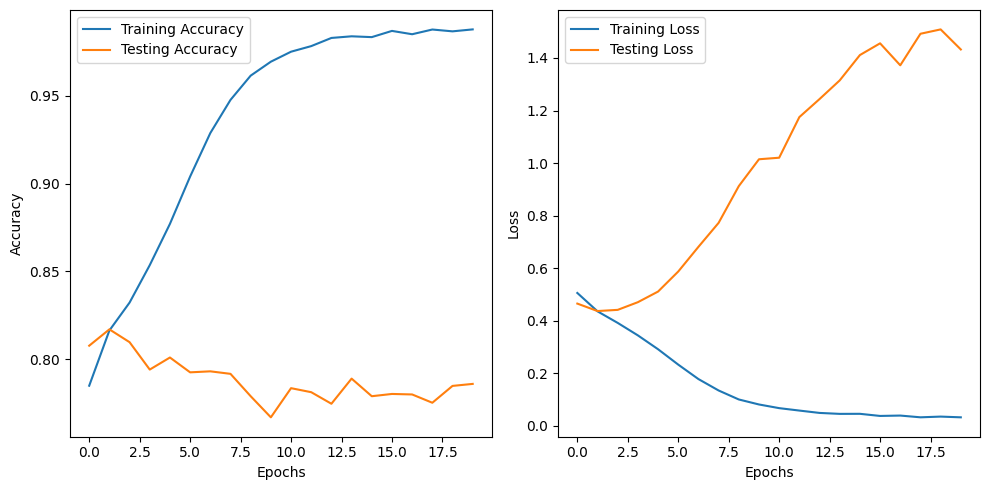

In [17]:
# Accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Losses
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

models_folder = proj_dir + '/src/models'
os.makedirs(models_folder, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': 5000,
    'embedding_dim': best_embedding_dim,
    'hidden_dim': best_hidden_dim,
    'output_dim': 2
}, 'models/lstm.pth')

# 2. Transformer Model

## Load and Preprocess data

In [18]:
from fakenews.preprocess import clean_text

tf_df = pd.read_csv(proj_dir+'/data/transformers.csv')
tf_df = tf_df.drop(columns=['Unnamed: 0'])
tf_df['text'] = tf_df['text'].map(lambda com : clean_text(com))

In [19]:
tf_df.isnull().sum()

text     0
label    0
dtype: int64

No null values in the data set

In [20]:
round(tf_df['label'].value_counts(normalize=True) * 100, 2)

0    90.22
1     9.78
Name: label, dtype: float64

In [21]:
# Sampling
undersampler = RandomUnderSampler(sampling_strategy=0.5)
oversampler = RandomOverSampler(sampling_strategy='minority')

# Resampling Pipeline
pipeline = Pipeline([
    ('undersample', undersampler),
    ('oversample', oversampler)
])

In [22]:
X_resampled, y_resampled = pipeline.fit_resample(np.array(tf_df['text']).reshape(-1, 1), tf_df['label'])
balanced_tf_df = pd.DataFrame()
balanced_tf_df['text'] = X_resampled.flatten()
balanced_tf_df['label'] = y_resampled

## Data Preparing

In [23]:
from fakenews.dataset import tokenize, data_loaders

X_train, X_test, y_train, y_test, tokenizer = tokenize(balanced_tf_df, proj_dir, "transformer")
train_loader, test_loader = data_loaders(X_train, X_test, y_train, y_test)

Maximum Sequence Length:  35


## Modelling: Bidirectional LSTM with Transformers

Finding best hyperparameters

In [24]:
from fakenews.model import Transformer
from fakenews.optimization import transformer_objective

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: transformer_objective(trial, train_loader, test_loader, device), n_trials=10)
best_params = study.best_params

best_embedding_dim = best_params['embedding_dim']
best_lstm_units_1 = best_params['lstm_units_1']
best_dropout_1 = best_params['dropout_1']
best_lstm_units_2 = best_params['lstm_units_2']
best_dropout_2 = best_params['dropout_2']

print("\n\nBest hyperparameters:", best_params)

input_dim = 5000  # Vocab size

model = Transformer(
      best_embedding_dim,
      best_lstm_units_1,
      best_dropout_1,
      best_lstm_units_2,
      best_dropout_2,
      input_dim
    ).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)
print(model)

[I 2023-12-11 02:00:18,116] A new study created in memory with name: no-name-18106f73-d304-4c80-9cce-758ce04bc4dd
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 



Best hyperparameters: {'embedding_dim': 160, 'lstm_units_1': 96, 'dropout_1': 0.2, 'lstm_units_2': 32, 'dropout_2': 0.30000000000000004}
Transformer(
  (embedding): Embedding(5000, 160)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=160, out_features=160, bias=True)
          )
          (linear1): Linear(in_features=160, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=160, bias=True)
          (norm1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((160,), eps=1e-05, elemen

Training

In [25]:
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device).long(), y_batch.to(device).long()
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        _, predicted = torch.max(outputs.data, 1)
        correct_train_preds += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    # Training accuracy and loss
    train_accuracy = correct_train_preds / total_train
    train_loss = total_train_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    total_test_loss = 0
    correct_test_preds = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device).long(), y_batch.to(device).long()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            _, predicted = torch.max(outputs.data, 1)
            correct_test_preds += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)
            total_test_loss += loss.item()

    # Test accuracy and loss
    test_accuracy = correct_test_preds / total_test
    test_loss = total_test_loss / len(test_loader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}')

Epoch 1, Training Loss: 0.6597, Training Accuracy: 0.6573, Validation Loss: 0.6831, Validation Accuracy: 0.5780
Epoch 2, Training Loss: 0.6240, Training Accuracy: 0.6779, Validation Loss: 0.5658, Validation Accuracy: 0.7820
Epoch 3, Training Loss: 0.5436, Training Accuracy: 0.7921, Validation Loss: 0.5075, Validation Accuracy: 0.8240
Epoch 4, Training Loss: 0.4888, Training Accuracy: 0.8482, Validation Loss: 0.4756, Validation Accuracy: 0.8440
Epoch 5, Training Loss: 0.4280, Training Accuracy: 0.9008, Validation Loss: 0.4273, Validation Accuracy: 0.9000
Epoch 6, Training Loss: 0.3962, Training Accuracy: 0.9299, Validation Loss: 0.4186, Validation Accuracy: 0.9000
Epoch 7, Training Loss: 0.4046, Training Accuracy: 0.9203, Validation Loss: 0.4940, Validation Accuracy: 0.8120
Epoch 8, Training Loss: 0.3896, Training Accuracy: 0.9304, Validation Loss: 0.4221, Validation Accuracy: 0.8920
Epoch 9, Training Loss: 0.3651, Training Accuracy: 0.9524, Validation Loss: 0.4101, Validation Accuracy:

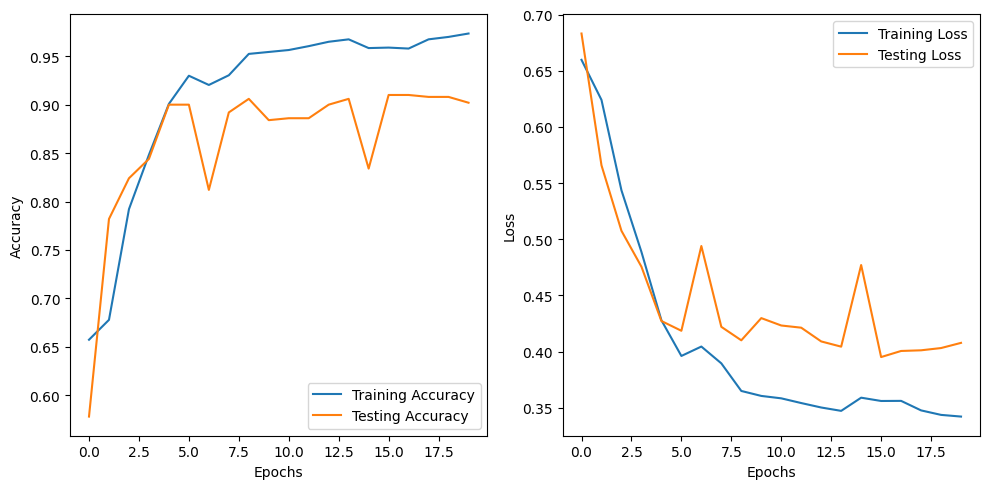

In [26]:
# Accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Losses
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

models_folder = proj_dir + '/src/models'
os.makedirs(models_folder, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'embedding_dim': best_embedding_dim,
    'lstm_units_1': best_lstm_units_1,
    'dropout_1': best_dropout_1,
    'lstm_units_2': best_lstm_units_2,
    'dropout_2': best_dropout_2,
    'vocab_size': input_dim
}, 'models/transformer.pth')

# 3. BERTLSTM Model

## Load and Preprocess data

In [27]:
from fakenews.preprocess import clean_text

tf_df = pd.read_csv(proj_dir+'/data/transformers.csv')
tf_df = tf_df.drop(columns=['Unnamed: 0'])
tf_df['text'] = tf_df['text'].map(lambda com : clean_text(com))

In [28]:
tf_df.isnull().sum()

text     0
label    0
dtype: int64

No null values in the data set

In [29]:
round(tf_df['label'].value_counts(normalize=True) * 100, 2)

0    90.22
1     9.78
Name: label, dtype: float64

In [30]:
# Sampling
undersampler = RandomUnderSampler(sampling_strategy=0.5)
oversampler = RandomOverSampler(sampling_strategy='minority')

# Resampling Pipeline
pipeline = Pipeline([
    ('undersample', undersampler),
    ('oversample', oversampler)
])

In [31]:
X_resampled, y_resampled = pipeline.fit_resample(np.array(tf_df['text']).reshape(-1, 1), tf_df['label'])
balanced_tf_df = pd.DataFrame()
balanced_tf_df['text'] = X_resampled.flatten()
balanced_tf_df['label'] = y_resampled

## Data Preparing

In [32]:
from fakenews.dataset import tokenize, data_loaders

X_train, X_test, y_train, y_test, tokenizer = tokenize(balanced_tf_df, proj_dir, "bert_lstm")
train_loader, test_loader = data_loaders(X_train, X_test, y_train, y_test)

Maximum Sequence Length:  35


## Modelling: BERT LSTM

Finding best hyperparameters

In [33]:
from fakenews.model import BERTLSTM
from fakenews.optimization import bertlstm_objective

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: bertlstm_objective(trial, train_loader, test_loader, device), n_trials=3)
best_params = study.best_params

best_lstm_units_1 = best_params['lstm_units_1']
best_dropout_1 = best_params['dropout_1']
best_lstm_units_2 = best_params['lstm_units_2']
best_dropout_2 = best_params['dropout_2']

print("\n\nBest hyperparameters:", best_params)

bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

model = BERTLSTM(
      bert_model,
      best_lstm_units_1,
      best_dropout_1,
      best_lstm_units_2,
      best_dropout_2,
      2
    ).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)
print(model)

[I 2023-12-11 02:01:59,688] A new study created in memory with name: no-name-4e439d92-458b-47cc-b6ab-86d1e2b5f0c9


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
[I 2023-12-11 02:04:09,643] Trial 0 finished with value: 0.6876199617981911 and parameters: {'lstm_units_1': 96, 'dropout_1': 0.2, 'lstm_units_2': 32, 'dropout_2': 0.5}. Best is trial 0 with va



Best hyperparameters: {'lstm_units_1': 96, 'dropout_1': 0.2, 'lstm_units_2': 32, 'dropout_2': 0.5}
BERTLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_

Training

In [34]:
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device).long(), y_batch.to(device).long()
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        _, predicted = torch.max(outputs.data, 1)
        correct_train_preds += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    # Training accuracy and loss
    train_accuracy = correct_train_preds / total_train
    train_loss = total_train_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    total_test_loss = 0
    correct_test_preds = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device).long(), y_batch.to(device).long()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            _, predicted = torch.max(outputs.data, 1)
            correct_test_preds += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)
            total_test_loss += loss.item()

    # Test accuracy and loss
    test_accuracy = correct_test_preds / total_test
    test_loss = total_test_loss / len(test_loader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.4f}')

Epoch 1, Training Loss: 0.6951, Training Accuracy: 0.4930, Validation Loss: 0.6952, Validation Accuracy: 0.4680
Epoch 2, Training Loss: 0.6903, Training Accuracy: 0.5160, Validation Loss: 0.6894, Validation Accuracy: 0.4680
Epoch 3, Training Loss: 0.6897, Training Accuracy: 0.4935, Validation Loss: 0.6897, Validation Accuracy: 0.4680
Epoch 4, Training Loss: 0.6894, Training Accuracy: 0.5110, Validation Loss: 0.6880, Validation Accuracy: 0.5420
Epoch 5, Training Loss: 0.6888, Training Accuracy: 0.5025, Validation Loss: 0.6878, Validation Accuracy: 0.4680
Epoch 6, Training Loss: 0.6953, Training Accuracy: 0.5015, Validation Loss: 0.6989, Validation Accuracy: 0.4680
Epoch 7, Training Loss: 0.6932, Training Accuracy: 0.5150, Validation Loss: 0.7061, Validation Accuracy: 0.4680
Epoch 8, Training Loss: 0.6937, Training Accuracy: 0.5190, Validation Loss: 0.6912, Validation Accuracy: 0.5320
Epoch 9, Training Loss: 0.6941, Training Accuracy: 0.4975, Validation Loss: 0.6936, Validation Accuracy:

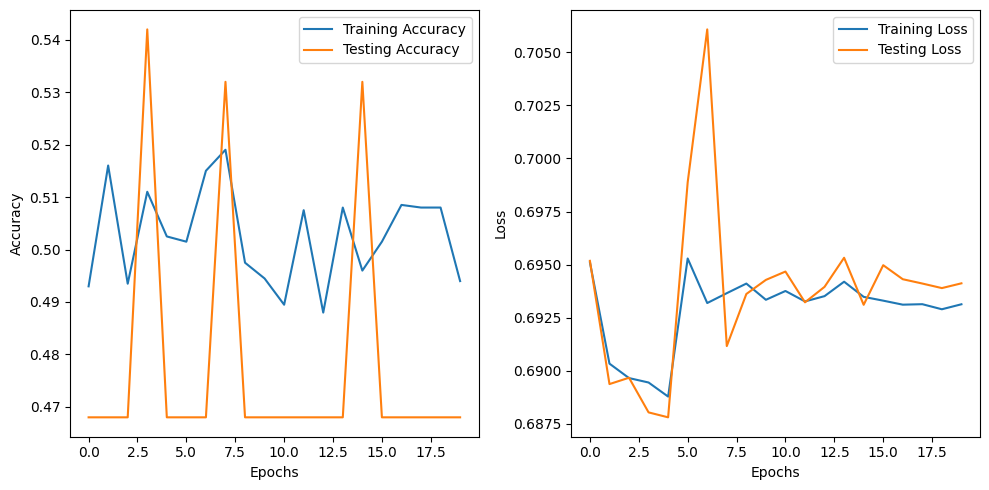

In [35]:
# Accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Losses
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


models_folder = proj_dir + '/src/models'
os.makedirs(models_folder, exist_ok=True)

torch.save(model.state_dict(), 'models/bert_lstm.pth') # Save the model

# Predict

In order to directly run the predictions without training again, first run the three cells in Basic setup

In [36]:
from fakenews.pipeline import pipeline

text = "Says Rick Perrys Pay to Play politics led him to send $899 million to an offshore call center in Bermuda, driving down enrollment in childrens health insurance"
print("The given sentence is", pipeline(text))

The given sentence is fake
